In [22]:
import numpy as np
import pandas as pd
import pymc as pm
import tools as tl

# Read the CSV files
data1_cd4 = pd.read_csv("small_dataset/Donor1_CD4_Genes.csv")
df = data1_cd4[["MT-CO1", "MT-CO2"]]
# Data
observed_X = np.array(df[["MT-CO1"]])
observed_Y = np.array(df[["MT-CO2"]])

FileNotFoundError: [Errno 2] No such file or directory: 'small_dataset/Donor1_CD4_Genes.csv'

In [23]:
import tools

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:721: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:721: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.



Correlation calculated using copula: 0.5468407909719678
            X          Y
0    4.208229  14.279872
1    3.426124  32.877291
2    7.545920   7.724850
3   10.764697  19.276305
4   16.484344  34.659281
..        ...        ...
95  29.069520  51.275826
96  23.149513  24.286187
97  13.904361  23.726457
98   8.615584  26.669055
99   0.296548  15.001175

[100 rows x 2 columns]


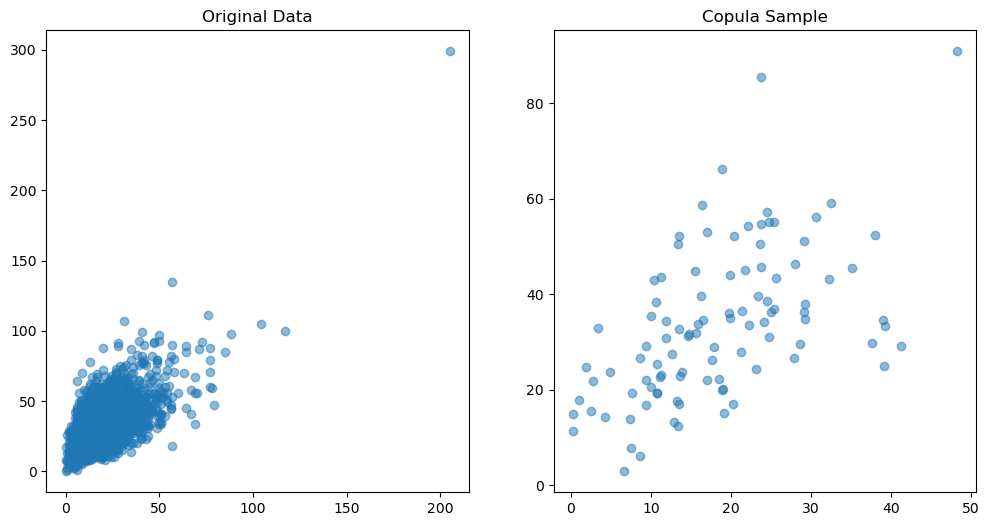

In [21]:

from copulas.multivariate import GaussianMultivariate
from copulas.visualization import scatter_2d

# 生成示例数据
np.random.seed(0)
n = 100
data = pd.DataFrame({
    'X': np.array(df[["MT-CO1"]]).reshape(-1),
    'Y': np.array(df[["MT-CO2"]]).reshape(-1)
})

# 创建并训练Gaussian Copula模型
copula = GaussianMultivariate()
copula.fit(data)

# 计算伪观测值（copula估计值）
pseudo_obs = copula.sample(n)

# 计算相关系数
correlation = pseudo_obs.corr().iloc[0, 1]

print(f'Correlation calculated using copula: {correlation}')

# 可视化数据和copula生成的样本
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(data['X'], data['Y'], alpha=0.5)
plt.title('Original Data')

plt.subplot(1, 2, 2)
plt.scatter(pseudo_obs['X'], pseudo_obs['Y'],alpha=0.5)
plt.title('Copula Sample')

print(pseudo_obs)
plt.show()


In [2]:
with pm.Model() as model:
    # Priors for the model parameters
    r = pm.Gamma('r', alpha=df['e_0'], beta=df['h'], shape=J)

    alpha = pm.Gamma('alpha', alpha=df['e_0'], beta=df['f_0'], shape=2)
    gamma = pm.Gamma('gamma', alpha=df['e_0'], beta=df['f_0'], shape=K)
    h = pm.Gamma('h', alpha=df['e_0'], beta=df['f_0'])

    # Initialize beta
    beta = pm.Normal('beta', mu=0, sigma=np.sqrt(1/alpha), shape=2)
    
    # Initialize Phi and theta
    Phi = pm.MvNormal('Phi', mu=np.zeros(V), cov=np.eye(2), shape=(2, 2))
    theta = pm.Normal('theta', mu=0, sigma=np.sqrt(1/gamma), shape=(J, 2))

    # Logistic function for p
    phi = pm.Deterministic('phi', np.dot(df['x'], beta.T) + np.dot(theta, Phi.T))
    p = pm.Deterministic('p', pm.math.sigmoid(phi))
    
    # Priors for the negative binomial parameters
    r_X = pm.Gamma('r_X', alpha=1.0, beta=1.0)
    r_Y = pm.Gamma('r_Y', alpha=1.0, beta=1.0)
    
    
    # Gaussian copula parameters
    chol, corr, stds = pm.LKJCholeskyCov('chol', n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0), compute_corr=True)
    
    # Copula latent variables
    u = pm.Normal('u', mu=0, sigma=1, shape=(2, len(observed_X)))
    copula_X = pm.Deterministic('copula_X', pm.math.invprobit(u[0, :]))
    copula_Y = pm.Deterministic('copula_Y', pm.math.invprobit(u[1, :]))

    # Negative Binomial likelihood
    X = pm.NegativeBinomial('X', mu=r_X * (1 - p_X) / p_X, alpha=r_X, observed=observed_X)
    Y = pm.NegativeBinomial('Y', mu=r_Y * (1 - p_Y) / p_Y, alpha=r_Y, observed=observed_Y)
    
    # Define a custom likelihood using the copula
    def bivariate_nb_likelihood(X, Y, r_X, p_X, r_Y, p_Y, corr):
        copula_X = pm.math.invprobit(X)
        copula_Y = pm.math.invprobit(Y)
        
        # Copula log likelihood
        copula_ll = (
            -0.5 * np.log(1 - corr[0, 1] ** 2)
            - 0.5 * (copula_X ** 2 + copula_Y ** 2 - 2 * corr[0, 1] * copula_X * copula_Y) / (1 - corr[0, 1] ** 2)
        )
        
        # Marginal Negative Binomial log likelihoods
        
        nb_X_ll = pm.logp(pm.NegativeBinomial.dist(mu=r_X * (1 - p_X) / p_X, alpha=r_X), r_X).sum().eval()
        nb_Y_ll = pm.logp(pm.NegativeBinomial.dist(mu=r_Y * (1 - p_Y) / p_Y, alpha=r_Y), r_Y).sum().eval()
        
        return copula_ll + nb_X_ll + nb_Y_ll

    # Custom likelihood
    pm.Potential('likelihood', bivariate_nb_likelihood(X, Y, r_X, p_X, r_Y, p_Y, corr))

    # Inference
    trace = pm.sample(20, tune=10, cores=2)

# Summary
pm.summary(trace)

Only 20 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [r_X, p_X, r_Y, p_Y, chol, u]


/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 10 tune and 20 draw iterations (20 + 40 draws total) took 11 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.
/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
chol[0],0.866,1.013,0.017,2.794,0.150,0.106,22.0,23.0,1.04
chol[1],1.009,0.657,0.300,2.338,0.160,0.115,16.0,50.0,1.11
chol[2],0.015,0.010,0.005,0.035,0.002,0.002,16.0,50.0,1.11
"chol_corr[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,40.0,40.0,NaN
"chol_corr[0, 1]",1.000,0.000,1.000,1.000,0.000,0.000,16.0,22.0,1.11
...,...,...,...,...,...,...,...,...,...
"u[1, 2883]",0.000,0.993,-1.587,1.359,0.150,0.110,47.0,57.0,1.00
"u[1, 2884]",-0.021,0.832,-1.261,1.194,0.151,0.155,32.0,51.0,1.13
"u[1, 2885]",-0.014,1.236,-2.267,1.877,0.154,0.151,64.0,50.0,1.02
"u[1, 2886]",0.010,0.968,-1.246,1.580,0.121,0.124,64.0,23.0,1.01


/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/density_utils.py:981: RuntimeWarning: divide by zero encountered in divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/density_utils.py:981: RuntimeWarning: invalid value encountered in divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/density_utils.py:700: RuntimeWarning: divide by zero encountered in divide
  f = grid_counts / bin_width / len(x)
/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/density_utils.py:700: RuntimeWarning: invalid value encountered in divide
  f = grid_counts / bin_wid

OverflowError: cannot convert float infinity to integer

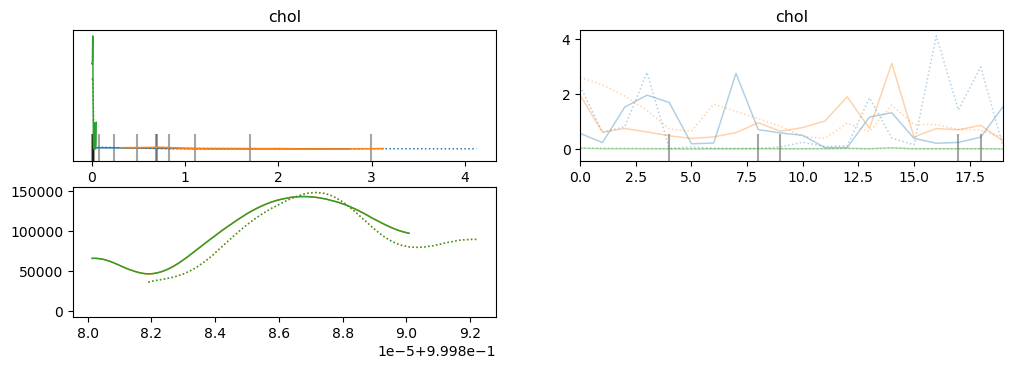

In [4]:
import matplotlib.pyplot as plt


# Plot trace of the samples
pm.plot_trace(trace)
plt.show()


In [7]:
import arviz as az
idata=pm.sample()
# Convert the trace to an ArviZ InferenceData object
az.plot_pair(idata, var_names=['r_X', 'p_X', 'r_Y', 'p_Y'], kind='kde')
plt.show()

TypeError: No model on context stack.

In [8]:
gamma = np.array([1.0, 4.0, 9.0, 16.0])  # Example vector

# Calculate the expression element-wise
result = 1 / np.sqrt(gamma)
print(result)

[1.         0.5        0.33333333 0.25      ]
